# Segment Anything Model as Inference

In [3]:
import os
import shutil
import csv
import warnings

import cv2
import pickle
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt

from skimage.filters import sobel, rank
from skimage.segmentation import watershed, felzenszwalb
from scipy import ndimage as ndi
from skimage.morphology import disk

from segment_anything import SamAutomaticMaskGenerator, sam_model_registry
import sklearn.metrics


## Importing and preparing work directory and data

In [4]:
# Define the path to the data directory and load the train labels and trains
DATA_PATH = "./../../data/"
data_dir = Path(DATA_PATH)
labels_train = pd.read_csv(data_dir / "Y_train.csv", index_col=0).T


def load_dataset(dataset_dir):
    dataset_list = []
    # Note: It's very important to load the images in the correct numerical order!
    for image_file in list(sorted(Path(dataset_dir).glob("*.png"), key=lambda filename: int(filename.name.rstrip(".png")))):
        dataset_list.append(cv2.imread(str(image_file), cv2.IMREAD_GRAYSCALE))
    return np.stack(dataset_list, axis=0)


data_train = load_dataset(data_dir / "X_train")


In [56]:
# We create a file containing only labeled X_train images to compute metrics using SAM for inference.
path_to_X_train = f'{DATA_PATH}X_train/'
path_to_X_train_ground_truth = f'{DATA_PATH}X_train_ground_truth'
os.makedirs(path_to_X_train_ground_truth, exist_ok=True)

# Copy the labeled images to the new folder
for i in range(201):
    image_path = os.path.join(path_to_X_train, str(i) + '.png')
    ground_truth_path = os.path.join(
        path_to_X_train_ground_truth, str(i) + '.png')
    shutil.copyfile(image_path, ground_truth_path)

# Create the predictions directory folder if it does not exist
predictions_dir = f'{DATA_PATH}predictions/inference_sam/'
os.makedirs(predictions_dir, exist_ok=True)

# Set the directory for inferenced images
inference_dir = f'{DATA_PATH}X_train_ground_truth/'


## Computing the inference

In [57]:
# Load the pre-trained Vision Transformer model using the SAM library
sam = sam_model_registry["vit_l"](
    checkpoint="./checkpoints_sam/sam_vit_l_0b3195.pth")


In [59]:
import pickle
from tqdm import tqdm

# Loop over each image in the directory with a progress bar
for filename in tqdm(os.listdir(inference_dir)):
    # Read the image and convert it to RGB
    image = cv2.imread(os.path.join(inference_dir, filename))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Generate the mask using the SamAutomaticMaskGenerator object
    mask_generator = SamAutomaticMaskGenerator(sam)
    masks = mask_generator.generate(image)

    # Remove the file extension for naming the files when saving outputs
    filename_without_extension = os.path.splitext(filename)[0]

    # Save the masks to a file
    with open(f'{predictions_dir}{filename_without_extension}.pkl', 'wb') as f:
        pickle.dump(masks, f)


  0%|          | 1/201 [01:05<3:37:56, 65.38s/it]


KeyboardInterrupt: 

## Vizualization and Comparison between ground truth and SAM output

In [61]:
# Choose the scan you want to plot
chosen_scan = 176

# Set the paths to the image and mask files
chosen_image = f"{DATA_PATH}/X_train_ground_truth/{chosen_scan}.png"
chosen_mask_file = f"{DATA_PATH}/predictions/inference_sam/{chosen_scan}.pkl"

# Load the mask from the pickle file
with open(chosen_mask_file, "rb") as f:
    chosen_mask = pickle.load(f)

# Load the image and convert it from BGR to RGB format
image = cv2.imread(chosen_image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


In [81]:
def show_sam(sam_output):
    """
    Show SAM segmentations.

    Args:
        sam_output (list): Output of SAM.

    Returns:
        None
    """

    if len(sam_output) == 0:
        return
    sorted_anns = sorted(sam_output, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:, :, i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))


def plot_slice_seg(slice_image, seg, image, mask):
    """
    Plot the original CT-scan, ground truth segmentation, and SAM output.

    Args:
        slice_image (np.ndarray): The original CT-scan slice.
        ground_truth_mask (np.ndarray): The ground truth segmentation mask.
        image (np.ndarray): The SAM output image.
        mask (list): Output of SAM.

    Returns:
        None
    """
    fig, axes = plt.subplots(1, 3, figsize=(12, 6))
    axes[0].imshow(slice_image, cmap="gray")
    axes[1].imshow(slice_image, cmap="gray")
    axes[2].imshow(image)
    show_sam(mask)
    seg_masked = np.ma.masked_where(seg.reshape(
        (512, 512)) == 0, (seg.reshape((512, 512))))
    axes[1].imshow(seg_masked, cmap="tab20")

    # Set titles for each axis
    axes[0].set_title("Original CT-Scan")
    axes[1].set_title("Ground Truth Segmentation")
    axes[2].set_title("SAM output")

    # Turn off the axis labels
    for ax in axes:
        ax.axis("off")


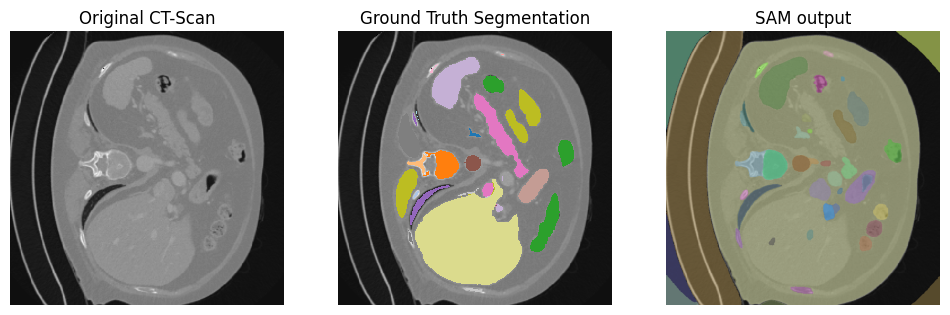

In [84]:
plot_slice_seg(data_train[chosen_scan], labels_train.iloc[chosen_scan].values.reshape(
    (512, 512)), image, chosen_mask)


Comments : We can observe that SAM tends to segment small parts of the CT-SCAN accurately. However, a major concern here is that it tends to segment the background and neglects the main organs.

## Computing some metrics